In [16]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "exploitation-zone-task2-images-text"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

In [21]:
from abc import ABC, abstractmethod
from PIL import Image, ImageEnhance, ImageFilter
import os
import io
import chromadb
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

client = chromadb.HttpClient(host="localhost", port=8000)
paginator = minio_client.get_paginator('list_objects_v2')
exploitation_zone = "exploitation-zone-task2-images-text"
trusted_zone = "trusted-zone"

model = OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()

try:
    client.delete_collection(name="multimodal-images")
except Exception:
    pass

try:
    collection = client.get_or_create_collection(
        name="multimodal-images",
        embedding_function=model,
        data_loader=image_loader
    )
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)

# FOR THE IMAGES NOW.
for page in paginator.paginate(Bucket=trusted_zone, Prefix="images/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        image_data = response['Body'].read()
        image = Image.open(io.BytesIO(image_data)).convert('RGB')

        temp_path = f"/tmp/{os.path.basename(key)}"
        image.save(temp_path)

        collection.add(
            ids=[key],
            uris=[temp_path],
            metadatas=[{"bucket": trusted_zone, "key": key}]
        )

        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
    
try:
    client.delete_collection(name="multimodal-text")
except Exception:
    pass

try:
    collection = client.get_or_create_collection(
        name="multimodal-text",
        embedding_function=model,
    )
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)
        
# FOR THE TEXT NOW.
for page in paginator.paginate(Bucket=trusted_zone, Prefix="text/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        document_content = response['Body'].read().decode('utf-8')
        
        collection.add(
            ids=[key],
            documents=[document_content],
            metadatas=[{"bucket": trusted_zone, "key": key}]
        )
        
        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
result = collection.get()
print("returned keys:", list(result.keys()))

returned keys: ['ids', 'embeddings', 'metadatas', 'documents', 'data', 'uris', 'included']


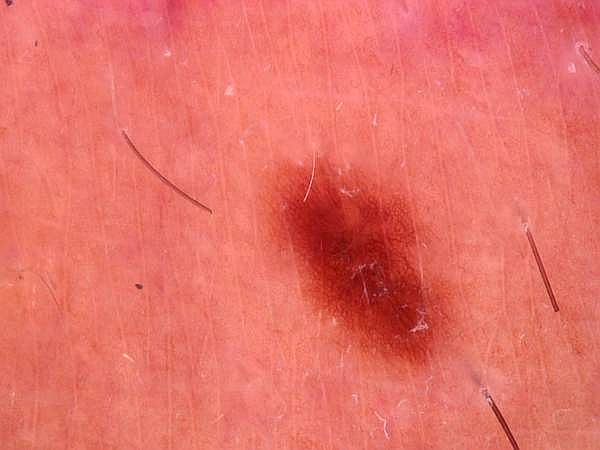

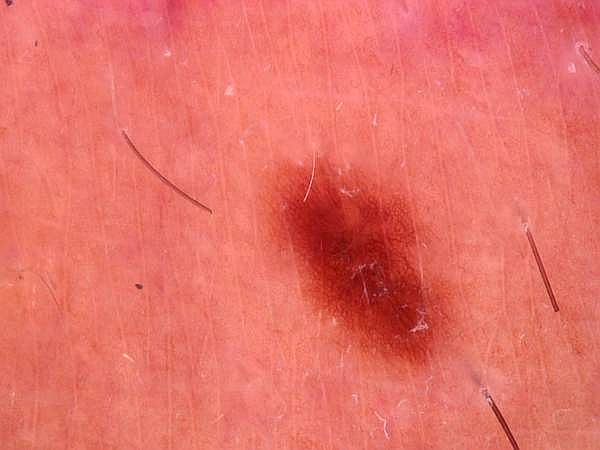


    → Melanoma is a type of skin cancer; it develops from the melanin-producing cells known as melanocytes. It typically occurs in the skin, but may rarely occur in the mouth, intestines, or eye (uveal mela...

    → Skin cancers are cancers that arise from the skin. They are due to the development of abnormal cells that have the ability to invade or spread to other parts of the body. It occurs when skin cells gro...



In [30]:
import numpy as np
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from IPython.display import display, Image as IPythonImage
from PIL import Image
import io, requests, os

embedding_function = OpenCLIPEmbeddingFunction()

# --- Recuperar col·leccions existents ---
images = client.get_collection(name="multimodal-images")
texts  = client.get_collection(name="multimodal-text")

# --- Consulta de text ---
query_text = "Lung Cancer"
query_emb = embedding_function([query_text])[0]
if hasattr(query_emb, "tolist"):
    query_emb = query_emb.tolist()

# --- Consultar imatges ---
image_results = images.query(
    query_embeddings=[query_emb],
    n_results=5,
    include=["metadatas", "distances"]
)

# --- Consultar textos ---
text_results = texts.query(
    query_embeddings=[query_emb],
    n_results=5,
    include=["documents", "metadatas", "distances"]
)

# --- Combinar resultats ---
combined = []

# Afegim imatges
for i, (id_, dist, meta) in enumerate(zip(
    image_results["ids"][0],
    image_results["distances"][0],
    image_results["metadatas"][0]
)):
    combined.append({
        "type": "image",
        "id": id_,
        "distance": dist,
        "meta": meta
    })

# Afegim textos
for i, (id_, dist, doc, meta) in enumerate(zip(
    text_results["ids"][0],
    text_results["distances"][0],
    text_results["documents"][0],
    text_results["metadatas"][0]
)):
    combined.append({
        "type": "text",
        "id": id_,
        "distance": dist,
        "text": doc,
        "meta": meta
    })

# --- Ordenar per distància (menor = més similar) ---
combined_sorted = sorted(combined, key=lambda x: x["distance"])

top_images = [r for r in combined_sorted if r["type"] == "image"][:2]
top_texts  = [r for r in combined_sorted if r["type"] == "text"][:2]
final_results = top_images + top_texts

for r in final_results:
        if r["type"] == "text":
            txt_preview = r["text"].strip().replace("\n", " ")
            print(f"    → {txt_preview[:200]}...\n")
        elif r["type"] == "image":
            if "http" in key:
                display(IPythonImage(url=key))
            else:
                try:
                    response = minio_client.get_object(Bucket=bucket, Key=key)
                    image_data = response["Body"].read()
                    img = Image.open(io.BytesIO(image_data))
                    display(img)
                except Exception as e:
                    print(f" No s'ha pogut mostrar la imatge: {e}")
            print()

